
===== Fold 1 =====
Training with seed 42
Early stopping (seed 42) at epoch 1193
Training with seed 52
Early stopping (seed 52) at epoch 1540
Training with seed 62
Early stopping (seed 62) at epoch 1126
Fold 1 Ensemble Test Accuracy: 0.8919

===== Fold 2 =====
Training with seed 42
Early stopping (seed 42) at epoch 1617
Training with seed 52
Early stopping (seed 52) at epoch 1248
Training with seed 62
Early stopping (seed 62) at epoch 1436
Fold 2 Ensemble Test Accuracy: 0.8493

===== Fold 3 =====
Training with seed 42
Early stopping (seed 42) at epoch 1084
Training with seed 52
Early stopping (seed 52) at epoch 1002
Training with seed 62
Early stopping (seed 62) at epoch 1523
Fold 3 Ensemble Test Accuracy: 0.8356

===== Fold 4 =====
Training with seed 42
Early stopping (seed 42) at epoch 812
Training with seed 52
Early stopping (seed 52) at epoch 1134
Training with seed 62
Early stopping (seed 62) at epoch 1071
Fold 4 Ensemble Test Accuracy: 0.7260

===== Fold 5 =====
Training with see

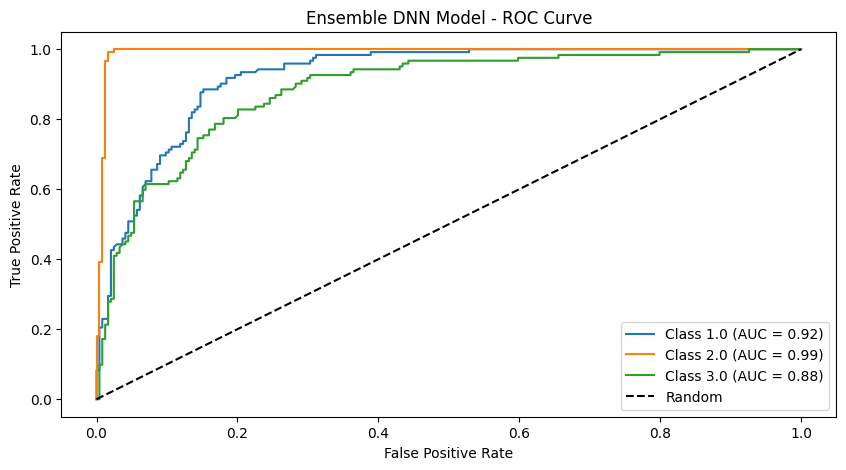

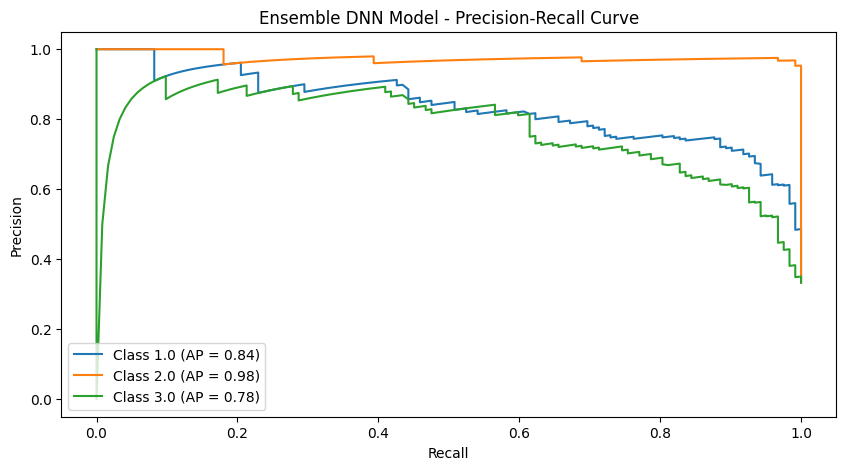

Accuracy: 0.8229 (95% CI: 0.7842–0.8607)

Macro AUC: 0.9340 (95% CI: 0.9130–0.9525)
Macro Average Precision: 0.8656 (95% CI: 0.8231–0.9029)


In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import SMOTE

# Load Data
merged_data = pd.read_csv("/Users/jiayingyou/Downloads/ar_mutants/merged_dataset.csv", index_col=False)
drug_data = pd.read_csv("/Users/jiayingyou/Downloads/ar_mutants/morgan_fp_drug_128.csv")
protein_data = pd.read_csv("/Users/jiayingyou/Downloads/ar_mutants/protein_desc_mutant.csv")

# Merge Data
merged_data = merged_data.merge(drug_data, on='drug')
merged_data = merged_data.merge(protein_data, on='mutant')

df = merged_data.iloc[:, 1:]  # Remove first column if unnecessary

# Feature Extraction
X = df.iloc[:, 3:].values  # Features
y = df['trend'].values      # Target Variable

# Standardization & PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=128)
X_pca = pca.fit_transform(X_scaled)

# Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Load Group Labels Before SMOTE
groups = df['mutant'].values  # Grouping based on mutant

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_encoded)

# Expand groups to match new SMOTE samples
new_groups = np.array([groups[i % len(groups)] for i in range(len(y_resampled))])

# Define GroupKFold cross-validation
gkf = GroupKFold(n_splits=5)

# Define Neural Network
class DNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob=0.3):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_dim)

        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.dropout3 = nn.Dropout(dropout_prob)

        self.init_weights()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

# Hyperparameters
input_dim = X_resampled.shape[1]
hidden_dims = [64, 32, 32]
output_dim = len(le.classes_)
learning_rate = 1e-4
batch_size = 64
epochs = 2000
patience = 20
ensemble_seeds = [42, 52, 62]  # Ensemble model seeds

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cv_results = []
all_true_labels = []
all_pred_probs = []

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_resampled, y_resampled, groups=new_groups)):
    print(f"\n===== Fold {fold + 1} =====")

    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    val_fraction = 0.2
    val_size = int(len(X_train) * val_fraction)
    val_idx = np.random.choice(len(X_train), size=val_size, replace=False)
    train_idx_subset = np.setdiff1d(np.arange(len(X_train)), val_idx)

    X_train_tensor = torch.tensor(X_train[train_idx_subset], dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train[train_idx_subset], dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_train[val_idx], dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_train[val_idx], dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    fold_pred_probs = []
    for seed in ensemble_seeds:
        print(f"Training with seed {seed}")
        torch.manual_seed(seed)
        np.random.seed(seed)

        model = DNNModel(input_dim, hidden_dims, output_dim, dropout_prob=0.3).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = nn.CrossEntropyLoss()(output, y_train_tensor)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_output = model(X_val_tensor)
                val_loss = nn.CrossEntropyLoss()(val_output, y_val_tensor)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping (seed {seed}) at epoch {epoch + 1}")
                    break

        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            test_output = model(X_test_tensor)
            pred_probs = torch.softmax(test_output, dim=1).cpu().numpy()
            fold_pred_probs.append(pred_probs)

    mean_pred_probs = np.mean(fold_pred_probs, axis=0)
    all_pred_probs.extend(mean_pred_probs)
    all_true_labels.extend(y_test)

    predicted_classes = np.argmax(mean_pred_probs, axis=1)
    test_accuracy = (predicted_classes == y_test).mean()
    print(f"Fold {fold + 1} Ensemble Test Accuracy: {test_accuracy:.4f}")
    cv_results.append(test_accuracy)

# Metrics
all_true_labels = np.array(all_true_labels)
all_pred_probs = np.array(all_pred_probs)

# Compute Mean Cross-Validation Accuracy
mean_accuracy = np.mean(cv_results)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}")

# ROC & Precision-Recall Curves
def plot_roc_curve(true_labels, pred_probs, model_name):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(output_dim):
        fpr[i], tpr[i], _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 5))
    for i in range(output_dim):
        plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(true_labels, pred_probs, model_name):
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(output_dim):
        precision[i], recall[i], _ = precision_recall_curve(true_labels == i, pred_probs[:, i])
        average_precision[i] = average_precision_score(true_labels == i, pred_probs[:, i])

    plt.figure(figsize=(10, 5))
    for i in range(output_dim):
        plt.plot(recall[i], precision[i], label=f'Class {le.classes_[i]} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Plot ROC and PR curves
plot_roc_curve(all_true_labels, all_pred_probs, 'Ensemble DNN Model')
plot_precision_recall_curve(all_true_labels, all_pred_probs, 'Ensemble DNN Model')

# Bootstrap Confidence Intervals
def bootstrap_metric_ci(metric_func, y_true, y_score, n_bootstrap=1000, ci=95):
    rng = np.random.default_rng(seed=42)
    boot_scores = []
    n_samples = len(y_true)

    for _ in range(n_bootstrap):
        indices = rng.choice(n_samples, size=n_samples, replace=True)
        try:
            score = metric_func(y_true[indices], y_score[indices])
            boot_scores.append(score)
        except ValueError:
            continue

    lower = np.percentile(boot_scores, (100 - ci) / 2)
    upper = np.percentile(boot_scores, 100 - (100 - ci) / 2)
    return np.mean(boot_scores), lower, upper


def bootstrap_accuracy_ci(y_true, y_pred, n_bootstrap=1000, ci=95):
    rng = np.random.default_rng(seed=42)
    boot_accuracies = []
    n_samples = len(y_true)

    for _ in range(n_bootstrap):
        indices = rng.choice(n_samples, size=n_samples, replace=True)
        acc = np.mean(y_true[indices] == y_pred[indices])
        boot_accuracies.append(acc)

    lower = np.percentile(boot_accuracies, (100 - ci) / 2)
    upper = np.percentile(boot_accuracies, 100 - (100 - ci) / 2)
    return np.mean(boot_accuracies), lower, upper
    
# Binarize labels for multiclass metrics
y_true_bin = label_binarize(all_true_labels, classes=range(output_dim))

# Assuming all_true_labels and all_pred_probs are defined
predicted_classes = np.argmax(all_pred_probs, axis=1)
acc_mean, acc_lower, acc_upper = bootstrap_accuracy_ci(all_true_labels, predicted_classes)

print(f"Accuracy: {acc_mean:.4f} (95% CI: {acc_lower:.4f}–{acc_upper:.4f})")

# Compute macro AUC and Average Precision
roc_auc_macro = roc_auc_score(y_true_bin, all_pred_probs, average='macro')
ap_macro = average_precision_score(y_true_bin, all_pred_probs, average='macro')

# Bootstrap 95% Confidence Intervals
auc_mean, auc_lower, auc_upper = bootstrap_metric_ci(
    lambda yt, yp: roc_auc_score(label_binarize(yt, classes=range(output_dim)), yp, average='macro'),
    all_true_labels, all_pred_probs
)

ap_mean, ap_lower, ap_upper = bootstrap_metric_ci(
    lambda yt, yp: average_precision_score(label_binarize(yt, classes=range(output_dim)), yp, average='macro'),
    all_true_labels, all_pred_probs
)

print(f"\nMacro AUC: {auc_mean:.4f} (95% CI: {auc_lower:.4f}–{auc_upper:.4f})")
print(f"Macro Average Precision: {ap_mean:.4f} (95% CI: {ap_lower:.4f}–{ap_upper:.4f})")
